In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [5]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('../_custom_/yolor/custom_yolor.py')

root='/opt/ml/detection/object-detection-level2-cv-04/dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (1024,1024) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=42
cfg.gpu_ids = [0]

cfg.work_dir = '/opt/ml/detection/object-detection-level2-cv-04/work_dirs/custom_yolor'

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

In [6]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [7]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

Use load_from_local loader


In [8]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 12.3 task/s, elapsed: 396s, ETA:     0s

In [9]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.12210218 171.97647 415.1317 216.9855 443.2...,test/0000.jpg
1,0 0.06376656 991.7858 479.247 1023.3608 559.93...,test/0001.jpg
2,0 0.09155451 334.2047 337.80576 715.29395 369....,test/0002.jpg
3,0 0.02942399 2.4333801 11.517395 954.0978 941....,test/0003.jpg
4,0 0.022130929 411.14502 394.74417 615.1642 578...,test/0004.jpg


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


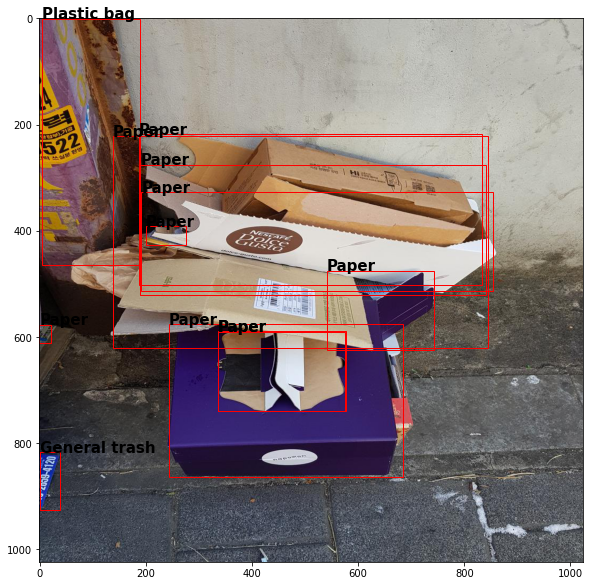

In [20]:
# visualize for check
import matplotlib.pyplot as plt
import matplotlib.patches as patches

coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 10
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

i = 4830

fix, ax = plt.subplots(figsize=(10,10))
image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
img = plt.imread(os.path.join('/opt/ml/detection/object-detection-level2-cv-04/dataset/', image_info['file_name']))

ax.imshow(img)

out = output[i]

for idx, c in enumerate(classes):
    for o in out[idx]: # category별

        if o[4] > 0.3:

            x = o[0]
            y = o[1]

            x1 = o[2]
            y1 = o[3]

            rect = patches.Rectangle((x,y), x1-x, y1-y, linewidth=1, edgecolor='r', facecolor='none')

            ax.add_patch(rect)
            ax.annotate(c, (x,y), color='black', weight='bold', fontsize=15)

        else:
            pass

plt.show()
plt.close()